# Abnormality Detection

The goal of this notebook is to explore abnormality detection with a Temporal Convolutional Network.

This notebook follows the work outlined by ["https://iopscience.iop.org/article/10.1088/1742-6596/1213/4/042050/pdf"]. Abnormality detection is done in an unsuperivized manner in which a TCN is trained to predict the next value in a time series on good data, or data without an abnormality. The assumption is that the model is well-trained and will predict the correct value, and the error between the prediction and the gound truth will be used as the metric to predict abnormality.

1.) Train with Early Stopping to prevent overfitting of the training data

2.) Fit a distribution to the losses of the trained model on the train data

3.) Set a threshold and equation from which to classify an anomaly

4.) Implement Model and abnormality detection on a test set


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tcn import TCN, tcn_full_summary

# Signal Creation

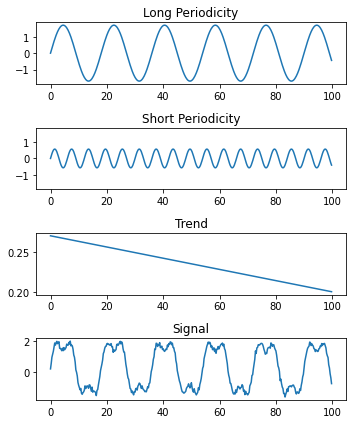

In [368]:
class SequenceGenerator():
    """
    This class will handle generating cyclic data and generating abnormal data. 
    """
    
    #Initialize random parameters that define the sequence
    def  __init__(self):
        
        #Define signal parameters
        self.sin1 = abs(np.random.randn()) + np.random.randint(low=1, high=2)
        self.sin2 = abs(np.random.randn()) + np.random.randint(low=0, high=1)
        self.trend = np.random.randn()/1000
        self.offset = (np.random.randn())
        self.sigma = .1
    
    #Generate a single sequence of data
    def generator(self, time=1000):
        
        #Generate time data
        t = np.arange(0, time, .01)
        
        #Calculate signal and trend values
        sin1 = self.sin1 * np.sin(np.pi / 9 * t)
        sin2 = self.sin2 * np.sin(np.pi / 3 * t)
        trend = (self.trend * t) + self.offset
        noise = np.random.normal(0, self.sigma, len(t))
        
        #Combine signals and noise to create a sequence
        signal = sin1 + sin2 + trend + noise
        
        return signal
    
    #Generate an abnormal sequence and mark the start and stop point
    def abnormality(self):
        
        #Generate a standard sequence
        
        #Select a random interval to intervene and add an abnormality
        
        #Generate abnormality in its place
        
        pass
    
    #Visualize the trends, seasonality, and noise
    def visualize(self):
        
        #Generate time data
        t = np.arange(0, 100, 0.25)
             
        #plot sin1
        plt.figure(1, figsize=(5,6))
        ax1 = plt.subplot(411)
        sin1 = self.sin1 * np.sin(np.pi / 9 * t)
        plt.plot(t,sin1)
        plt.title("Long Periodicity")
        
        #plot sin2
        ax2 = plt.subplot(412, sharex=ax1, sharey=ax1)
        sin2 = self.sin2 * np.sin(np.pi / 3 * t)
        plt.plot(t, sin2)
        plt.title("Short Periodicity")
        
        #plot trend
        ax3 = plt.subplot(413, sharex=ax1)
        trend = (self.trend * t) + self.offset
        plt.plot(t, trend)
        plt.title("Trend")
        
        #Add Guassian Noise
        noise = np.random.normal(0, self.sigma, len(t))
        
        #plot all
        ax4 = plt.subplot(414, sharex=ax1)
        signal = sin1 + sin2 + trend + noise
        plt.plot(t, signal)
        plt.title("Signal")
        plt.tight_layout()
        pass
    
    
SequenceGenerator = SequenceGenerator()

SequenceGenerator.visualize()

# Dataset
Now, that we have a signal that we can generate, deconstruct and visualize, it's time to create a windowed dataset. The windowed dataset will turn a signal into a dataset where the model will be able to see window_size number of entries before predicting the next entry. It's a common way to breakdown a time series prediction problem.

In [359]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Turns a series of data into a windowed dataset, amenable for training on a tf.Model
    """
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# TCN Model

In [360]:
def buildTCNModel(WINDOW_SIZE):
    """
    Inputs:
    WINDOW_SIZE   (INT): The window size used for training examples
    
    Outputs:
    TCNMdoel: Uncompiled TCN model (tf.keras.Model)
    """
    #Determine dilatations based on length of sequnce
    kernel = 4
    nb_stacks = 1                   
    dilatations = [1,2,4,8]


    #Setup TCN architecture
    tcn_layer = TCN(
        input_shape =(WINDOW_SIZE,1),
        nb_filters=256,
        kernel_size=kernel,
        nb_stacks=nb_stacks,
        dilations=dilatations,
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.0,
        return_sequences=False,
        activation='relu',
        kernel_initializer='he_normal',
        use_batch_norm=False,
        use_layer_norm=False,
        use_weight_norm=True
    )

    #Create a Tensorflow model
    inputs = tf.keras.Input((WINDOW_SIZE,1))
    x = tcn_layer(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(1)(x)
    out = tf.math.multiply(x, 5)
    
    TCNModel = tf.keras.models.Model(inputs, out)
    
    return TCNModel

# Training

In [369]:
#Generate a signal
signal = SequenceGenerator.generator(1000000)

#Transform signal into a windowed dataset
WINDOW_SIZE = 32
BATCH_SIZE = 16
SHUFFLE_BUFFER = 100
train_set = windowed_dataset(signal,
                            window_size=WINDOW_SIZE,
                            batch_size=BATCH_SIZE,
                            shuffle_buffer=SHUFFLE_BUFFER)

#Build Model
TCNModel = buildTCNModel(WINDOW_SIZE)

#Compile Model
TCNModel.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=["mae"])

#Setup early stopping
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)


#Train Model
history = TCNModel.fit(train_set, epochs=100,
                      steps_per_epoch=16, callbacks = [EarlyStopping])

Epoch 1/100
16/16 [==============================] - 5s 107ms/step - loss: 5.3903 - mae: 5.8667
Epoch 2/100
16/16 [==============================] - 2s 108ms/step - loss: 1.8592 - mae: 2.3100
Epoch 3/100
16/16 [==============================] - 2s 106ms/step - loss: 2.6160 - mae: 3.0900
Epoch 4/100
16/16 [==============================] - 2s 106ms/step - loss: 9.3137 - mae: 9.7920
Epoch 5/100
16/16 [==============================] - 2s 106ms/step - loss: 14.6914 - mae: 15.1850
Epoch 6/100
16/16 [==============================] - 2s 106ms/step - loss: 5.4057 - mae: 5.9008
Epoch 7/100
16/16 [==============================] - 2s 107ms/step - loss: 2.4719 - mae: 2.9412
Epoch 8/100
16/16 [==============================] - 2s 107ms/step - loss: 0.7268 - mae: 1.1450
Epoch 9/100
16/16 [==============================] - 2s 107ms/step - loss: 0.3689 - mae: 0.7190
Epoch 10/100
16/16 [==============================] - 2s 106ms/step - loss: 0.3599 - mae: 0.6979
Epoch 11/100
16/16 [=================

In [419]:
signal = SequenceGenerator.generator(100)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

forecast = model_forecast(TCNModel, signal, WINDOW_SIZE)

error = signal[32:] - forecast

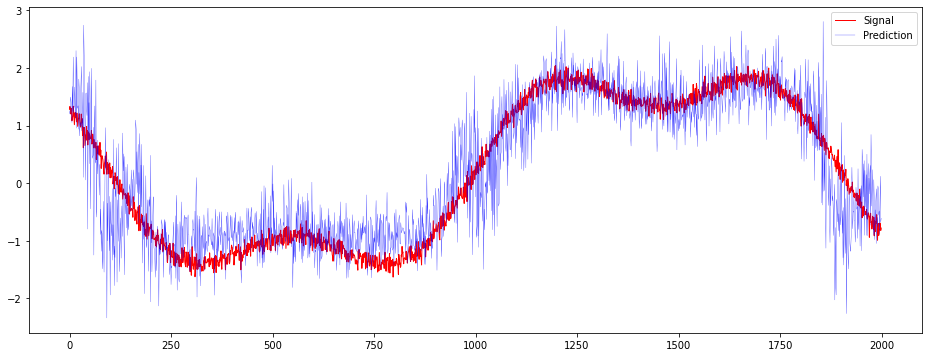

In [420]:
plt.figure(figsize=(16, 6))
plt.plot(signal[-2000:], 'r', linewidth=1, label="Signal")
plt.plot(forecast[-2000:], 'b', linewidth=0.25, label="Prediction")
plt.legend()

# Error Analysis

In [461]:
from scipy.stats import norm

# Fit a normal distribution to the error
parameters = norm.fit(error)
print("Error Fit:")
print("Mean: {}, Standard Deviation: {}".format(parameters[0], parameters[1]))

#Fitted Distribution
x = np.arange(-8, 8, .25)
pdf_fitted = norm.pdf(x,loc=parameters[0],scale=parameters[1])

Error Fit:
Mean: -0.04726488288817409, Standard Deviation: 1.756163035725556


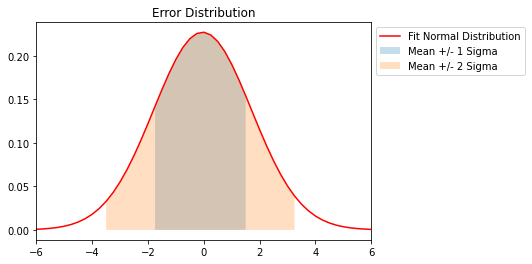

In [486]:
plt.title('Error Distribution')
plt.plot(x,pdf_fitted,'r-', label="Fit Normal Distribution")
plusminus1Sigma = (x>parameters[0] - (1*parameters[1])) & (x<parameters[0] + (1*parameters[1]))
plusminus2Sigma = (x>parameters[0] - (2*parameters[1])) & (x<parameters[0] + (2*parameters[1]))
plt.fill_between(x, pdf_fitted, where=plusminus1Sigma, alpha=.25,label="Mean +/- 1 Sigma")
plt.fill_between(x, pdf_fitted, where=plusminus2Sigma, alpha=.25,label="Mean +/- 2 Sigma")
plt.xlim([-6,6])
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

# Abnormality Detection

In [565]:
#Create an abnormal signal
signal = SequenceGenerator.generator(50)
signal[2300:2500] = 0

In [552]:
forecast = model_forecast(TCNModel, signal, WINDOW_SIZE)
signal = signal[:-31]

error = signal - np.squeeze(forecast)

In [570]:
def abnormality(error, threshold):
    t = list(range(len(signal)))
    plt.figure(figsize=(16, 6))
    plt.plot(t[:], signal[:], 'b', label="Signal",linewidth=.5)
    plt.plot(t[2300:2500], signal[2300:2500], 'r', label="Abnormality", linewidth=2)
    plt.ylim([-2, 4])
    plt.legend()
    
    plt.figure(figsize=(16, 6))
    plt.plot(t[2000:3000], signal[2000:3000], 'b', label="Signal",linewidth=.5)
    plt.plot(t[2300:2500], signal[2300:2500], 'r', label="Abnormality", linewidth=2)
    plt.plot(t[2000:3000], forecast[2000:3000], 'k', label="Prediction", linewidth=.5)
    plt.ylim([-2, 4])
    plt.legend()
        

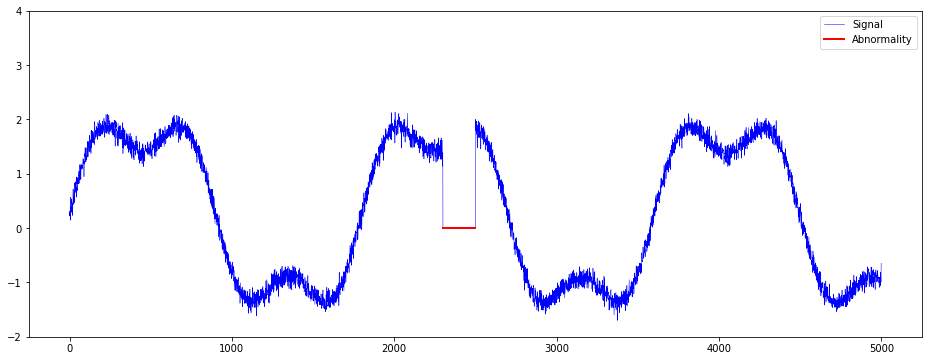

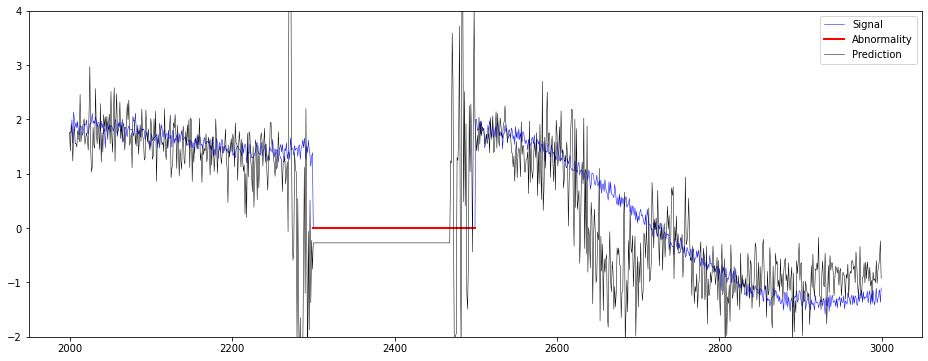

In [571]:
abnormality(error, 1)